<a href="https://colab.research.google.com/github/mnansary/pytfBusterNet/blob/master/fusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# colab specific task
*   mount google drive
*   change working directory to git repo
*   Check TF version
*    TPU check



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd /content/gdrive/My\ Drive/CopyMove/pytfBusterNet/

/content/gdrive/My Drive/CopyMove/pytfBusterNet


In [3]:
!pip3 install tensorflow==1.13.1

## TPU Check

In [4]:
import os
import pprint
import tensorflow as tf

if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

tf.__version__

TPU address is grpc://10.101.157.130:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 4761961009959105818),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 5638059082635466872),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 18016856909551166751),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 6947801159749927165),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 17060972187671535414),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 16873963880719943249),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 1523699779303488709),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 14906596199184025070),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 1830306717

'1.13.1'

# Fusion Model Training

## IMPORT

In [5]:
# imports for fusion_net and loading
from BusterNet.models import fusion_net
import h5py
import numpy as np

# read data
def readh5(d_path):
    data=h5py.File(d_path, 'r')
    data = np.array(data['data'])
    return data

# load data
d_path=os.path.join(os.getcwd(),'DataSet')
Xmp=os.path.join(d_path,'Xm.h5')
Xsp=os.path.join(d_path,'Xs.h5')
Yp=os.path.join(d_path,'Y.h5')

Xm=readh5(Xmp)
Xs=readh5(Xsp)
Y=readh5(Yp)

print(Xm.shape)
print(Xs.shape)
print(Y.shape)

Using TensorFlow backend.


(672, 256, 256, 1)
(672, 256, 256, 1)
(672, 256, 256, 3)


## Compile Model

In [7]:
from tensorflow.keras.optimizers import Adam
model=fusion_net()
model.summary()
model.compile(optimizer=Adam(lr=0.01), loss=tf.keras.losses.categorical_crossentropy)


Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256, 256, 2)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None

## Convert Model

In [8]:
# This address identifies the TPU we'll use when configuring TensorFlow.
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tf.logging.set_verbosity(tf.logging.INFO)

def convert_model_TPU(model):
  return tf.contrib.tpu.keras_to_tpu_model(model,strategy=tf.contrib.tpu.TPUDistributionStrategy(tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

model=convert_model_TPU(model)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.101.157.130:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 4761961009959105818)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 5638059082635466872)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 18016856909551166751)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU

## Training Parameters

In [0]:
epochs=250
batch_size=30

## Train

In [10]:
history=model.fit([Xs,Xm],Y,epochs=epochs,batch_size=batch_size, verbose=1)

Epoch 1/250
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(3,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(3, 256, 256, 1), dtype=tf.float32, name='input_1_10'), TensorSpec(shape=(3, 256, 256, 1), dtype=tf.float32, name='input_2_10'), TensorSpec(shape=(3, 256, 256, 3), dtype=tf.float32, name='lambda_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning Adam {'lr': 0.009999999776482582, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Remapping placeholder for input_2
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7f04d8583cc0> []
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
INFO:tensorflow:Started compiling
I

## Save Model Weights

In [11]:
model.save_weights('fusion_net.h5')

INFO:tensorflow:Copying TPU weights to the CPU
INFO:tensorflow:TPU -> CPU lr: 0.009999999776482582
INFO:tensorflow:TPU -> CPU beta_1: 0.8999999761581421
INFO:tensorflow:TPU -> CPU beta_2: 0.9990000128746033
INFO:tensorflow:TPU -> CPU decay: 0.0
INFO:tensorflow:TPU -> CPU epsilon: 1e-07
INFO:tensorflow:TPU -> CPU amsgrad: False


## Plot Training Histoty

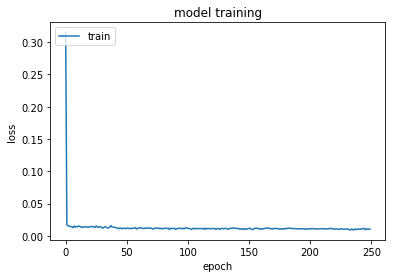

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.title('model training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')